# ARIMA(Autoregressive Integrated Moving Average) Model

整合移动平均自回归模型，是时间序列预测分析方法之一。

3 components p, d and q, pdq非负整数:

- AR(p) Autoregression
- I(d) Integrated
- MA(q) Moving Average

用于分析非平稳性non-stationary的时序数据(无法呈现出一个长期趋势并最终趋于一个常数或是一个线性函数).

## 笔记

#### 1. 粗略查看数据做做exploration

把时间作为idnex设好，画图，做Moving Avg，做ETS decomposition，有无seasonal，有无trend。

#### 2. 判断数据是否是平稳的

ARIMA是在平稳的时间序列基础上建立起来的，因此时间序列的平稳性是建模的重要前提。

用Augmented Dickey-Fuller unit root test做假设检验，零假设是non-stationary。

什么是非平稳数据？

- no constant mean
- variance is a function of time
- covariance is a function of time

#### 3. 如果数据是非平稳的，先用differencing转化

用第n项数据减去第n-1项，一次一次.shift(1)做直到数据变平稳，但是每做一次每次最前面的那个数据就会被损失掉变NA。

如果是seasonal data，可以考虑先尝试difference by a season，比如yearly seasonality可以difference by a time unit of 12就是直接.shift(12)。

实在不行就先difference一次再seasonal difference一次。总有一款能弄出stationary.

#### 4. 确定自相关系数和平均移动系数

是用AR(p)，还是MA(q)，还是both(less common)?

法一：画图目测

选AR还是MA用ACF

判断是否用AR model最好用PACF图判断，判断是否用MA model最好用ACF图

- 如果Autocorrelation图的第一个lag是正的，用AR

- 第一个lag是负的，用MA

p: The num of lag observations included in the model

d: The num of times that the raw observations are differenced

q: The size of the moving average

partial correlation是conditional correlation

一般来说如果在lag "k"后有个sharp drop 就说明应该使用AR-k model.如果是gradual decline,就用MA model


法二：Grid Search

但是R提供了自动化的方法来解决这个问题 ，但尚未被移植到Python中。淦！

#### 5. ARIMA and Seasonal ARIMA

ARIMA: p d q

Seasonal ARIMA: need an additional set of P,D,Q terms，也就是ARIMA(p,d,q)(P,D,Q,s),其中s是时间序列的周期

#### 6. ARIMA模型建好了可以开始做预测了

## Whole Process

The general process for ARIMA models is the following:
* Visualize the time series data
* Testing for stationarity 
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('./monthly-milk-production-pounds-p.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [3]:
df.columns = ['Month', 'Milk in pounds per cow']
df # the last row needs to be deleted

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0
...,...,...
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [4]:
# clean and format
# delete the last row
df.drop([len(df) - 1], axis=0, inplace=True)
# format the Month column and set it to be the index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


### **1 Visualize the Time Series Data**



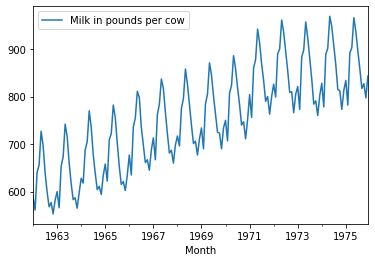

In [5]:
df.plot() 

It appears to be seasonal data and has a trend.

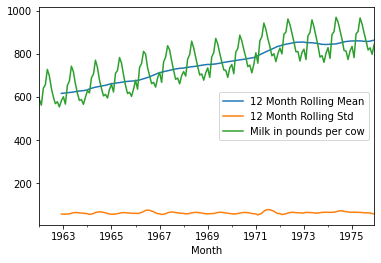

In [6]:
timeseries = df['Milk in pounds per cow']
# 12 month rolling simple average is a reflection of the yearly moving average
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

There is some sort of upward trend here and the std deviation is pretty flat.

#### ETS Decomposition
 
ETS decomposition allows us to see the individual parts!

（不记得就去看statsmodel那个notebook

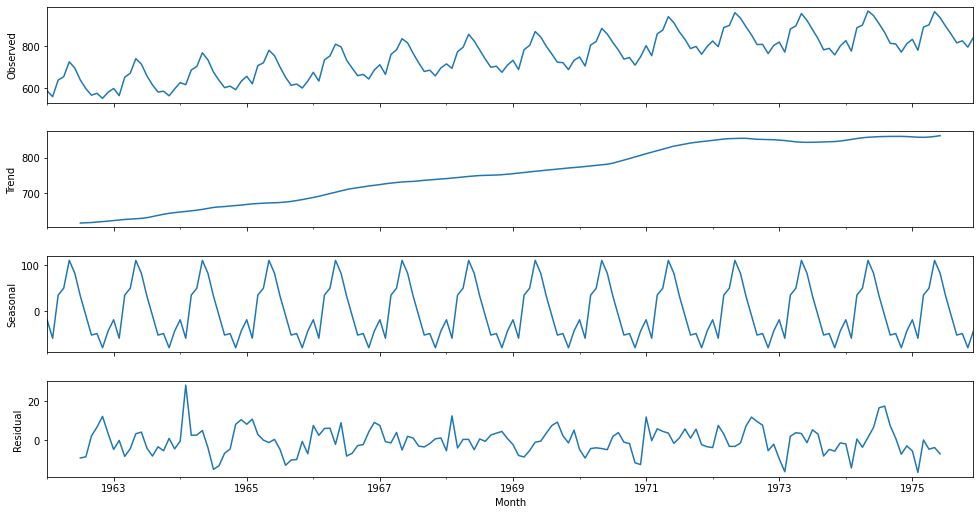

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
# if you wanted to make sure that every period was a yearly period for the season you could set the frequency to be 12 
# fig = plt.figure()  
fig = decomposition.plot()  # 之前如果直接画图会出两个图的bug，如果只想要出一张图就这样写
fig.set_size_inches(15, 8)

We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data

**Typically financial stock data won't be seasonal, that won't work well on stock finance data!**

### **2 Testing for Stationarity**

Use the Augmented Dickey-Fuller unit root test.

一般的设置都是：

- Null Hypothesis H0: the time series has a unit root, indicating it is non-stationary

- Alternative Hypo: no unit root, stationary

计算p-value:

- A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

- A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.




In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Milk in pounds per cow'])

In [9]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


OK 现在知道这数据non-stationary要做difference

### **3 Make the time series data stationary**

The first difference of a time series is the series of changes from one period to the next. You can continue second difference, third difference, until the data is stationary.

#### The 1st difference

In [11]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [12]:
# 重复第二步的验证操作
adf_check(df['Milk First Difference'].dropna())   ## 切记要dropna

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586531126
p-value : 0.030068004001782136
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


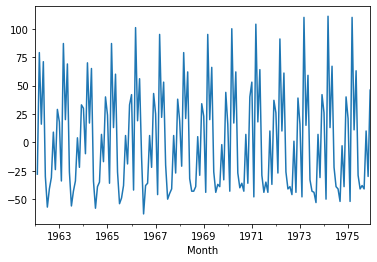

In [13]:
df['Milk First Difference'].plot()

OK 第一次做完已经是stationary了可以不用做第二次了，如果要做第二次就：

df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

#### Seasonal Difference

In [14]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Seasonal Difference by itself was not enough!

#### Seasonal First Difference

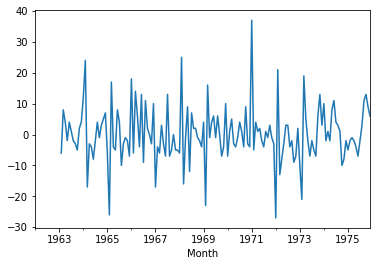

In [15]:
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [16]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921983
p-value : 1.865423431878848e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


所以对于这种seasonal的数据，可以直接做difference（可能会需要做很多次），也可以直接尝试seasonal difference，实在不行也可以拿第一次差分后的再做seasonal difference，只要能把数据快速弄成stationary就行。

### **4 Plot the Correlation and AutoCorrelation Plots**

An autocorrelation plot (also known as a Correlogram) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.



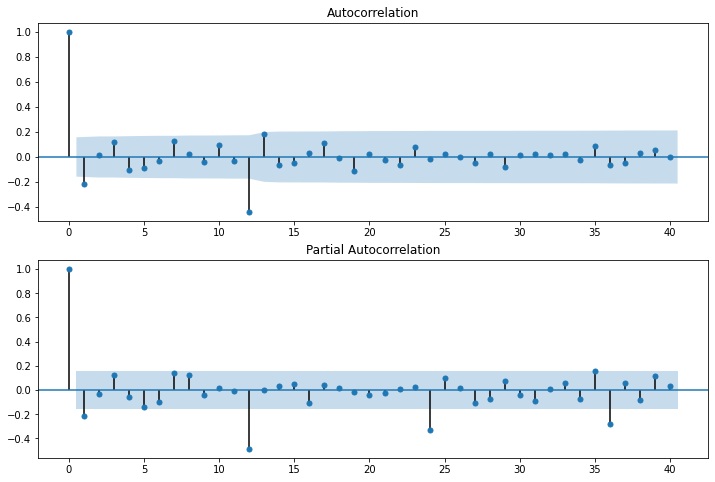

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
# 可以选任意一个能将数据变稳定的difference来做，这里iloc 13行相当于dropna，因为difference每shift一次会报废最前的那个数
# 之前提到的打出duplicated图的bug，需要assign一下就可以了fig = ...
fig = plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

In [18]:
# pandas自己其实也可以画ACF，但是画不了PACF图
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df['Seasonal First Difference'].dropna())

所以根据这两个图得知，ACF图第一个是正的，并且PACF图是sharp drop并且在第一个lag之后断崖下跌，就说明应该使用AR-1 model，草到底他妈怎么选天杀的

#### 法二：Grid Search + Akaike's Information Criterion (AIC)

教程有一部分我没搞清楚 就是怎么用图目测选参数

第一个目标是找到优化感兴趣度量的ARIMA(p,d,q)(P,D,Q)s的值。 实现这一目标有许多指导方针和最佳实践，但ARIMA模型的正确参数化可能是一个需要领域专长和时间的艰苦的手工过程。。。那就网格搜索找最优参数

In [19]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))  # itertools.product是这三个东西的笛卡尔积，用来解决py循环贼慢用的
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print(pdq)
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


try Akaike's Information Criterion (AIC) on a set of models and investigate the models with the lowest AIC values：

In [20]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

y = timeseries
aic = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try: # 由于某些参数组合可能导致数字错误指定，可能导致错误并引发异常，因此要try块来捕获这些异常并忽略导致这些问题的参数组合
      mod = sm.tsa.statespace.SARIMAX(y,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      
      results = mod.fit()
      aic.append(results.aic)
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2692.5389822312172
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2328.2101960814985
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1443.9444260476184
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1305.3386049260541
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1340.0277737960891
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1334.413560850845
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1299.9128017700104
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1241.4893843261166
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2467.3808782288597
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2120.253292197983
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1298.1255645574083
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1189.1245489150783
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1232.1197580907697
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1215.8038072397048
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1204.6588818319924
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1135.6410375389655
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1739.8839094674686
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1475.65353653

In [21]:
min(aic)

965.6194210434703


OK，所以grid search真的比画图目测法好多了，接下来选AIC最低的那个（AIC用来衡量模型如何适应数据，同时考虑到模型的整体复杂性。）

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:965.6194210434703

所以接下来的ARIMA参数是(0, 1, 1)x(0, 1, 1, 12)

### **5 Using the Seasonal ARIMA model**

In [22]:
# For non-seasonal data
# from statsmodels.tsa.arima_model import ARIMA
#help(ARIMA) 

In [23]:

model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(0,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -534.140
Date:                            Fri, 22 Jan 2021   AIC                           1072.280
Time:                                    23:45:23   BIC                           1078.367
Sample:                                01-01-1962   HQIC                          1074.752
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6110      0.066     -9.285      0.000      -0.740      -0.482
sigma2        55.5966      5.322   

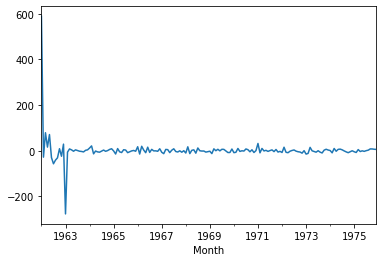

In [24]:
results.resid.plot()  # show residual error point，smooth的是正常值

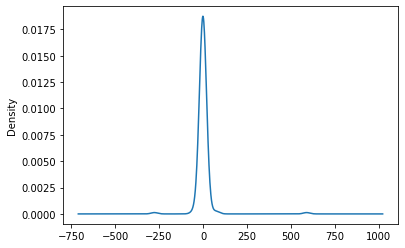

In [25]:
results.resid.plot(kind='kde') # 核密度图

### 6 Prediction of Future Values

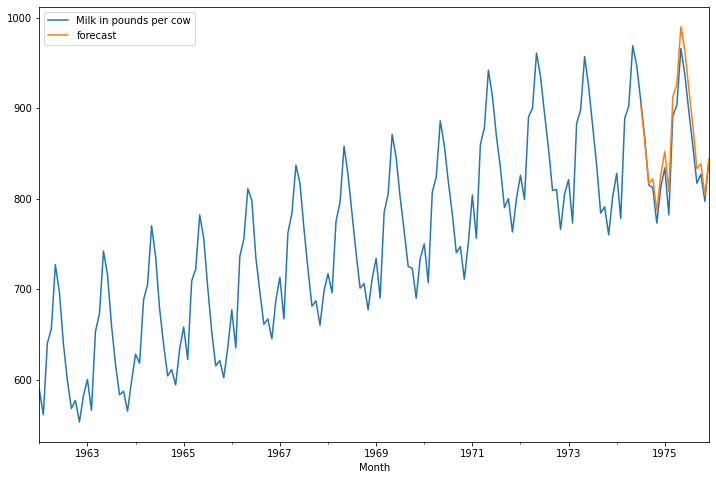

In [26]:
# 先预测一下已知的部分看看效果咋样
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)   # 此数据一共168 rows
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

OK 看起来还是不错的，接下来是正规forecasting

In [27]:
from pandas.tseries.offsets import DateOffset

# generate future dates that we wanna use the model to predict
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]
# 两年 1975-12-01 00:00:00 到 1977-11-01 00:00:00

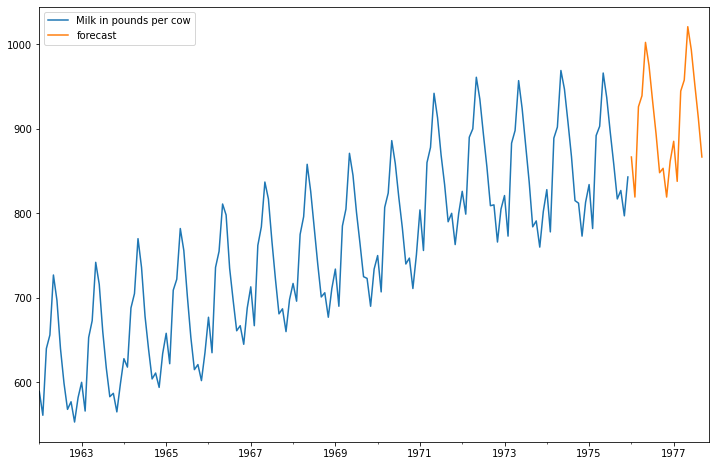

In [28]:
# add future dates to original date column
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df = pd.concat([df,future_dates_df])
future_df['forecast'] = results.predict(start = 168, end = 188, dynamic= True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8)) 

ARIMA模型用来处理一些季度销售数据完全OK，但是很难受的是不太适用大部分的financial data。